# Imports and Custom Functions

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
#import tensorflow as tf
#tf.enable_v2_behavior()

#import tensorflow_probability as tfp
#tfd = tfp.distributions
#tfb = tfp.bijectors

In [2]:
def closest(lst, K):
    
    number = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    
    if abs(number-K) >= 3:
        print('Not close enough: ', int(abs(number-K)))
    
    # number_index = np.random.choice(get_all_indices(lst,number))
      
    return get_all_indices(lst,number) # number_index

In [3]:
def get_all_indices(mylist,myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

In [4]:
def remove_zeros_distribution(X):

    return [i for i in X if i != 0]

def log_binning_distribution(x_i,B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))

    # b_list.insert(0,b_1)
    # b_list.append(b_Bp1)
    
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

# Analysis of BindingDB Kd

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

There are 70750 drug target pairs.


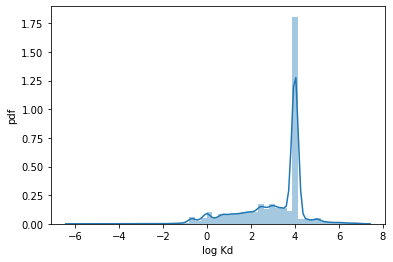

In [5]:
df = pd.read_csv('/home/sars-busters-consolidated/data/BindingDB_All.tsv', sep = '\t', error_bad_lines=False)

df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[df_want.Label <= 10000000.0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')

kd_list = list(df_want.Label.values)

ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')
plt.show()

# Randomzing the whole bipartite network

In [6]:
#threshold = 30 # in nM

df_want_Kd = df_want[['SMILES','Target Sequence','Label']]
#df_want_Kd['Kd'] = df_want.Label.values
#df_want_Kd['Label'] = [1 if x<threshold else 0 for x in kd_list]

In [7]:
df_want_Kd

,SMILES,Target Sequence,Label
21470,Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.46
21471,COc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.49
21472,NS(=O)(=O)c1ccc(s1)S(=O)(=O)NCc1cccs1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.83
21473,NS(=O)(=O)c1cc2C(O)CN(Cc3cccs3)S(=O)(=O)c2s1,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.20
21474,COc1ccc(cc1)N1CC(O)c2cc(sc2S1(=O)=O)S(N)(=O)=O,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.16
...,...,...,...
2077352,CCCC(=O)c1ccc2Sc3ccccc3N(CCCN3CCN(C)CC3)c2c1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,16600.00
2077353,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc23)CC1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,63100.00
2077354,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)C#N,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,34700.00
2077355,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,38900.00


In [8]:
threshold = 30 

df_want_Kd_binary = pd.DataFrame(df_want_Kd)
df_want_Kd_binary['Label'] = [1 if x < threshold else 0 for x in tqdm(df_want_Kd['Label'].tolist())]

100%|██████████| 70750/70750 [00:00<00:00, 1640818.83it/s]


In [9]:
ligands = list(set(df_want_Kd_binary['SMILES'].tolist()))
targets = list(set(df_want_Kd_binary['Target Sequence'].tolist()))

In [10]:
ligand_annotations_bindingDB = []
ligand_pos_degree_bindingDB = []
ligand_neg_degree_bindingDB = []
ligand_degree_ratio_bindingDB = []

for chem in tqdm(ligands):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['SMILES'] == chem]
    ligand_annotations_bindingDB.append(len(sub_df))
    ligand_pos_degree_bindingDB.append(sub_df['Label'].tolist().count(1))
    ligand_neg_degree_bindingDB.append(sub_df['Label'].tolist().count(0))
    ligand_degree_ratio_bindingDB.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 13392/13392 [01:52<00:00, 119.33it/s]


In [11]:
target_annotations_bindingDB = []
target_pos_degree_bindingDB = []
target_neg_degree_bindingDB = []
target_degree_ratio_bindingDB = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations_bindingDB.append(len(sub_df))
    target_pos_degree_bindingDB.append(sub_df['Label'].tolist().count(1))
    target_neg_degree_bindingDB.append(sub_df['Label'].tolist().count(0))
    target_degree_ratio_bindingDB.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 1507/1507 [00:12<00:00, 119.65it/s]


In [12]:
p_connection_layer = len(df_want_Kd_binary) / (len(ligands)*len(targets))

In [13]:
randomized_combined_bipartite = nx.Graph(bipartite.random_graph(len(ligands), len(targets), p_connection_layer))

In [14]:
randomized_combined_bipartite.number_of_edges()

70984

In [15]:
top_nodes = {n for n, d in randomized_combined_bipartite.nodes(data=True) if d["bipartite"] == 0}

print(len(top_nodes))

bottom_nodes = set(randomized_combined_bipartite) - top_nodes

print(len(bottom_nodes))

13392
1507


# Target Annotaions and Kd

In [16]:
df_want_Kd = df_want[['SMILES','Target Sequence','Label']]

In [17]:
targets = list(set(df_want_Kd['Target Sequence']))
target_annotations = []
target_average_Kd = []

#df_want_Kd = df_want_Kd[df_want_Kd['Label'] != 0]
df_want_Kd['Label'] = list(df_want_Kd['Label'].tolist())

for prot in tqdm(targets):
    sub_df = df_want_Kd[df_want_Kd['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_average_Kd.append(np.mean(sub_df['Label'].tolist()))
    
different_target_annotations = list(set(target_annotations))
unique_Kd_targets = []
unique_Kd_targets_std = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(target_average_Kd[j])
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    unique_Kd_targets_std.append(np.std(all_Kd_list))
    
print('Targets - Between k and <Kd>: ', stats.spearmanr(different_target_annotations,unique_Kd_targets))

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 172/172 [00:00<00:00, 5655.76it/s]

Targets - Between k and <Kd>:  SpearmanrResult(correlation=-0.4673048395959652, pvalue=1.0298775028113185e-10)


Mean and standard deviation of log Kd:  7.104377155054556 3.333661394378017


Text(0, 0.5, 'Average $K_d$')

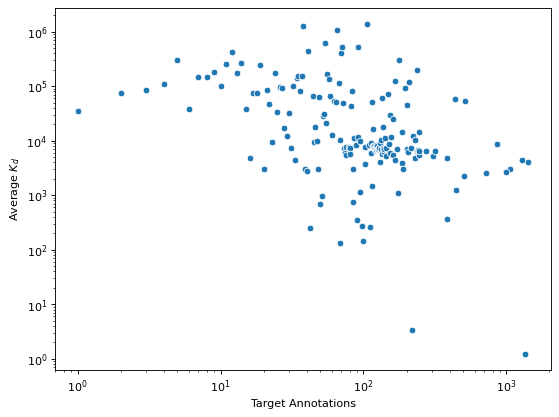

In [18]:
mean_log_Kd = np.mean(np.log(remove_zeros_distribution(kd_list)))
std_log_Kd = np.std(np.log(remove_zeros_distribution(kd_list)))

print('Mean and standard deviation of log Kd: ', mean_log_Kd, std_log_Kd)

figure(figsize=(8, 6), dpi=80)

sns.scatterplot(different_target_annotations,unique_Kd_targets)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Target Annotations')
plt.ylabel(r'Average $K_d$')

In [19]:
mean_poisson = np.mean([randomized_combined_bipartite.degree(node) for node in bottom_nodes]) 
# mean_poisson = np.mean(ligand_annotations_bindingDB)
print('Average annotations for targets: ', mean_poisson)

Average annotations for targets:  47.102853351028536


In [20]:
mean = [0, 0]
cov = [[1, 0], [0, 1]] # No correlation 

In [21]:
x, y = np.random.multivariate_normal(mean, cov, size=100000).T

In [22]:
from scipy.stats import norm  

U1 = norm.cdf(x)
U2 = norm.cdf(y)

In [23]:
K_copula_list = []
Kd_copula_list = []

for i in tqdm(range(len(U1))):
    K_copula_list.append(poisson.ppf(U1[i], mean_poisson, loc=0))
    Kd_copula_list.append(np.exp(mean_log_Kd + std_log_Kd*norm.ppf(U2[i])))

100%|██████████| 100000/100000 [00:34<00:00, 2915.82it/s]


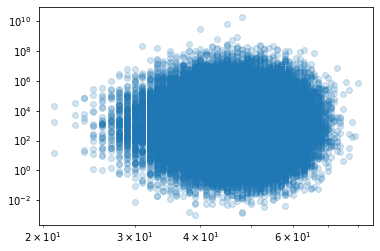

In [24]:
plt.scatter(K_copula_list,Kd_copula_list,alpha=0.2)
plt.xscale('log')
plt.yscale('log')

In [25]:
stats.spearmanr(Kd_copula_list,K_copula_list)

SpearmanrResult(correlation=-0.0070527765469608535, pvalue=0.025728619388225904)

# Adding Randomized Kd Values

In [26]:
top_nodes = list({n for n, d in randomized_combined_bipartite.nodes(data=True) if d["bipartite"] == 0})

print(len(top_nodes))

bottom_nodes = list(set(randomized_combined_bipartite).difference(set(top_nodes)))

print(len(bottom_nodes))

13392
1507


In [27]:
target_random_Kd_dict = dict()

for node in tqdm(bottom_nodes):
    degree_node = randomized_combined_bipartite.degree(node)
    #closest_index = closest(K_copula_list,degree_node)
    closest_indices = closest(K_copula_list,degree_node)
    Kd_all_list = []
    for index in closest_indices:
        Kd_all_list.append(Kd_copula_list[index])
    target_random_Kd_dict[node] = Kd_all_list

100%|██████████| 1507/1507 [02:37<00:00,  9.58it/s]


Text(0, 0.5, 'Kd Chosen')

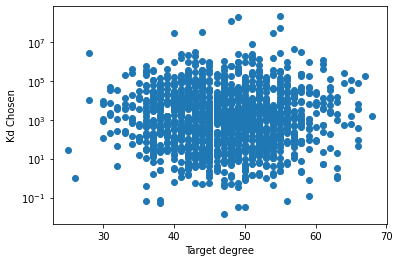

In [28]:
plt.scatter([randomized_combined_bipartite.degree(node) for node in bottom_nodes],[np.random.choice(target_random_Kd_dict[node]) for node in bottom_nodes])
plt.yscale('log')
plt.xlabel('Target degree')
plt.ylabel('Kd Chosen')

In [29]:
stats.spearmanr([randomized_combined_bipartite.degree(node) for node in bottom_nodes],[np.random.choice(target_random_Kd_dict[node]) for node in bottom_nodes])

SpearmanrResult(correlation=-0.012996340652511863, pvalue=0.6141757420601154)

In [261]:
target_random_Kd_dict[14000]

[0.6546518804036027,
 341895.10335140594,
 50514.49036224982,
 208.0556012644833,
 14789.126438167928,
 1184.637210756803,
 11237834.308799246,
 33.38295225876662,
 42.40227811634253,
 121.24604092450804,
 3040.9456734224855,
 1547.319469286699,
 104.13820571469503,
 26004.578511440126,
 4358.724780979737,
 1808.5682038516663,
 2199.054512275056,
 250.59237931247083,
 2559.418237493196,
 480.48704951872827,
 509.480366405138,
 174.15115356876154,
 5065.7674524798,
 285.6849676059837,
 12898.676546429639,
 110.09895494180367,
 4.914484918228874,
 32885.99056195085,
 122.92261036816537,
 270.22275616164467,
 12.363412452377341,
 47.62923861110789,
 207.7727616823984,
 96.32764263470672,
 144.47394754640524,
 563.3435934424202,
 128.412881706026,
 101.17844417021702,
 123.03615196472728,
 27832.953493884143,
 2977.316177646677,
 138.61602011706353,
 31734.202119116213,
 20352.548660465694,
 6582.460863300195,
 478.80814472872584,
 293.90447433752126,
 452.81792476131267,
 748938.813814546

In [32]:
smiles_list = []
targets_list = []
Kd_for_edges = []

for edge in tqdm(randomized_combined_bipartite.edges()):
    #if 13702 in edge:
    #    print(edge)
    smiles_list.append(ligands[edge[0]])
    targets_list.append(targets[edge[1] - len(ligands)])
    mu = np.random.choice(target_random_Kd_dict[edge[1]])
    if randomized_combined_bipartite.degree(edge[1]) in different_target_annotations:
        sigma = unique_Kd_targets_std[different_target_annotations.index(randomized_combined_bipartite.degree(edge[1]))]
    else:
        sigma = 0
    Kd_for_edges.append(np.random.normal(mu, sigma, 1))

100%|██████████| 70984/70984 [00:48<00:00, 1458.81it/s]


# Making DataFrame

In [33]:
randomized_dataframe = pd.DataFrame()

randomized_dataframe['SMILES'] = smiles_list
randomized_dataframe['Target Sequence'] = targets_list
randomized_dataframe['Label'] = Kd_for_edges

In [34]:
randomized_dataframe

,SMILES,Target Sequence,Label
0,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MAADLGPWNDTINGTWDGDELGYRCRFNEDFKYVLLPVSYGVVCVP...,[12567.234885062828]
1,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MSEREVSTAPAGTDMPAAKKQKLSSDENSNPDLSGDENDDAVSIES...,[-12236.90983775258]
2,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MAVPPGHGPFSGFPGPQEHTQVLPDVRLLPRRLPLAFRDATSAPLR...,[-94960.26309531482]
3,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MAGRSGDSDEELIRTVRLIKLLYQSNPPPNPEGTRQARRNRRRRWR...,[-55429.57993844897]
4,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MLAPGSSRVELFKRKNSTVPFEDKAGKVTERVVHSFRLPALVNVDG...,[27895.66674027664]
...,...,...,...
70979,CNc1cc(nc2c(cnn12)C(=O)NC1CCC1)-c1cn(C(C)C)c2n...,MDPAGGPRGVLPRPCRVLVLLNPRGGKGKALQLFRSHVQPLLAEAE...,[170576.08229625275]
70980,Nc1ccc(cc1NC(=O)N1CC2CCC(C1)O2)-c1ccncc1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,[14823.236327594414]
70981,Nc1ccc(cc1NC(=O)N1CC2CCC(C1)O2)-c1ccncc1,MVFLSGNASDSSNCTHPPPPVNISKAILLGVILGGLILFGVLGNIL...,[6.44684552751552]
70982,Nc1ccc(cc1NC(=O)N1CC2CCC(C1)O2)-c1ccncc1,MRYRLAWLLHPALPSTFRSVLGARLPPPERLCGFQKKTYSKMNNPA...,[3743.5868930818688]


In [35]:
threshold = 30 ##np.exp(np.mean(np.log(Kd_for_edges)))
print('Threshold: ', threshold)

binary_labels = [1 if x < threshold else 0 for x in tqdm(randomized_dataframe['Label'].tolist())]

randomized_dataframe['Label'] = binary_labels

100%|██████████| 70984/70984 [00:00<00:00, 388087.21it/s]

Threshold:  30


In [36]:
randomized_dataframe

,SMILES,Target Sequence,Label
0,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MAADLGPWNDTINGTWDGDELGYRCRFNEDFKYVLLPVSYGVVCVP...,0
1,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MSEREVSTAPAGTDMPAAKKQKLSSDENSNPDLSGDENDDAVSIES...,1
2,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MAVPPGHGPFSGFPGPQEHTQVLPDVRLLPRRLPLAFRDATSAPLR...,1
3,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MAGRSGDSDEELIRTVRLIKLLYQSNPPPNPEGTRQARRNRRRRWR...,1
4,CC(=O)N1C2CCC1CN(C2)C(=O)Nc1cc(ccc1N)-c1ccncc1,MLAPGSSRVELFKRKNSTVPFEDKAGKVTERVVHSFRLPALVNVDG...,0
...,...,...,...
70979,CNc1cc(nc2c(cnn12)C(=O)NC1CCC1)-c1cn(C(C)C)c2n...,MDPAGGPRGVLPRPCRVLVLLNPRGGKGKALQLFRSHVQPLLAEAE...,0
70980,Nc1ccc(cc1NC(=O)N1CC2CCC(C1)O2)-c1ccncc1,MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGL...,0
70981,Nc1ccc(cc1NC(=O)N1CC2CCC(C1)O2)-c1ccncc1,MVFLSGNASDSSNCTHPPPPVNISKAILLGVILGGLILFGVLGNIL...,1
70982,Nc1ccc(cc1NC(=O)N1CC2CCC(C1)O2)-c1ccncc1,MRYRLAWLLHPALPSTFRSVLGARLPPPERLCGFQKKTYSKMNNPA...,0


In [37]:
print(randomized_dataframe['Label'].tolist().count(0))
print(randomized_dataframe['Label'].tolist().count(1))

50594
20390


In [38]:
ligands = list(set(randomized_dataframe['SMILES'].tolist()))
targets = list(set(randomized_dataframe['Target Sequence'].tolist()))

In [39]:
ligand_annotations_randomized = []
ligand_pos_degree_randomized = []
ligand_neg_degree_randomized = []
ligand_degree_ratio_randomized = []

for chem in tqdm(ligands):
    sub_df = randomized_dataframe[randomized_dataframe['SMILES'] == chem]
    ligand_annotations_randomized.append(len(sub_df))
    ligand_pos_degree_randomized.append(sub_df['Label'].tolist().count(1))
    ligand_neg_degree_randomized.append(sub_df['Label'].tolist().count(0))
    ligand_degree_ratio_randomized.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 13317/13317 [01:51<00:00, 118.98it/s]


In [40]:
target_annotations_randomized = []
target_pos_degree_randomized = []
target_neg_degree_randomized = []
target_degree_ratio_randomized = []

for prot in tqdm(targets):
    sub_df = randomized_dataframe[randomized_dataframe['Target Sequence'] == prot]
    target_annotations_randomized.append(len(sub_df))
    target_pos_degree_randomized.append(sub_df['Label'].tolist().count(1))
    target_neg_degree_randomized.append(sub_df['Label'].tolist().count(0))
    target_degree_ratio_randomized.append(sub_df['Label'].tolist().count(1)/(sub_df['Label'].tolist().count(1)+sub_df['Label'].tolist().count(0)))

100%|██████████| 1507/1507 [00:12<00:00, 119.54it/s]


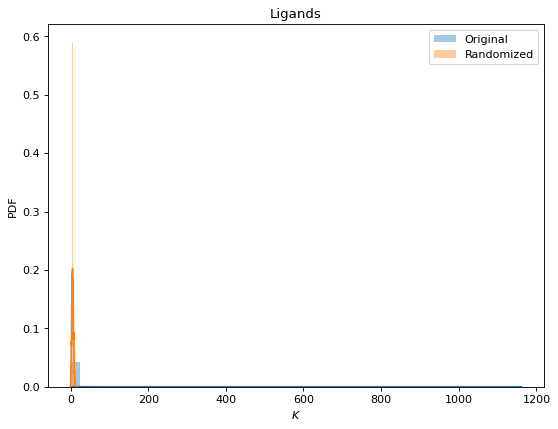

In [41]:
figure(figsize=(8, 6), dpi=80)

sns.distplot(ligand_annotations_bindingDB, norm_hist=True, label='Original')
sns.distplot(ligand_annotations_randomized, norm_hist=True, label='Randomized')
#axs[3, 0].set_xscale('log')
#axs[3, 0].set_yscale('log')
plt.title('Ligands')
plt.xlabel(r'$K$')
plt.ylabel('PDF')
plt.legend()

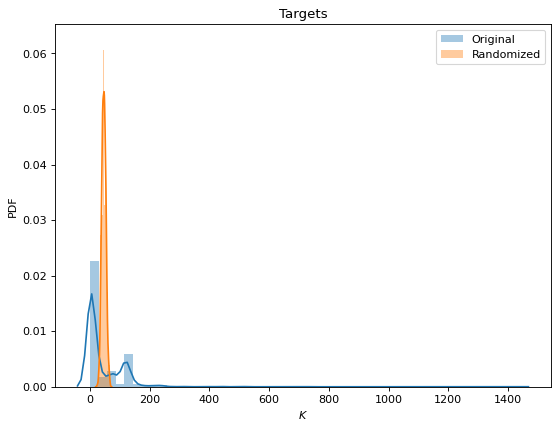

In [42]:
figure(figsize=(8, 6), dpi=80)

sns.distplot(target_annotations_bindingDB, norm_hist=True, label='Original')
sns.distplot(target_annotations_randomized, norm_hist=True, label='Randomized')
#axs[3, 0].set_xscale('log')
#axs[3, 0].set_yscale('log')
plt.title('Targets')
plt.xlabel(r'$K$')
plt.ylabel('PDF')
plt.legend()

In [43]:
print('LIGANDS')

print('Original - Between k and k+: ', stats.spearmanr(ligand_annotations_bindingDB, ligand_pos_degree_bindingDB))
print('Original - Between k and k-: ', stats.spearmanr(ligand_annotations_bindingDB, ligand_neg_degree_bindingDB))
print('Original - Between k+ and k-: ', stats.spearmanr(ligand_pos_degree_bindingDB, ligand_neg_degree_bindingDB))

print('-------------------------------------------------------------------------------------------------------------')

print('Shuffled - Between k and k+: ', stats.spearmanr(ligand_annotations_randomized, ligand_pos_degree_randomized))
print('Shuffled - Between k and k-: ', stats.spearmanr(ligand_annotations_randomized, ligand_neg_degree_randomized))
print('Shuffled - Between k+ and k-: ', stats.spearmanr(ligand_pos_degree_randomized, ligand_neg_degree_randomized))


print('-------------------------------------------------------------------------------------------------------------')

print('-------------------------------------------------------------------------------------------------------------')

print('TARGETS')

print('Original - Between k and k+: ', stats.spearmanr(target_annotations_bindingDB, target_pos_degree_bindingDB))
print('Original - Between k and k-: ', stats.spearmanr(target_annotations_bindingDB, target_neg_degree_bindingDB))
print('Original - Between k+ and k-: ', stats.spearmanr(target_pos_degree_bindingDB, target_neg_degree_bindingDB))

print('-------------------------------------------------------------------------------------------------------------')

print('Shuffled - Between k and k+: ', stats.spearmanr(target_annotations_randomized, target_pos_degree_randomized))
print('Shuffled - Between k and k-: ', stats.spearmanr(target_annotations_randomized, target_neg_degree_randomized))
print('Shuffled - Between k+ and k-: ', stats.spearmanr(target_pos_degree_randomized, target_neg_degree_randomized))

LIGANDS
Original - Between k and k+:  SpearmanrResult(correlation=0.19228830229942806, pvalue=1.0182463611750579e-111)
Original - Between k and k-:  SpearmanrResult(correlation=0.5837365393100225, pvalue=0.0)
Original - Between k+ and k-:  SpearmanrResult(correlation=-0.5965683639069678, pvalue=0.0)
-------------------------------------------------------------------------------------------------------------
Shuffled - Between k and k+:  SpearmanrResult(correlation=0.5019882724433475, pvalue=0.0)
Shuffled - Between k and k-:  SpearmanrResult(correlation=0.8296919004004206, pvalue=0.0)
Shuffled - Between k+ and k-:  SpearmanrResult(correlation=-0.022199401667926073, pvalue=0.010411004971900553)
-------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------
TARGETS
Original - Between k and k+:  SpearmanrResult(correlation=0.6581040571

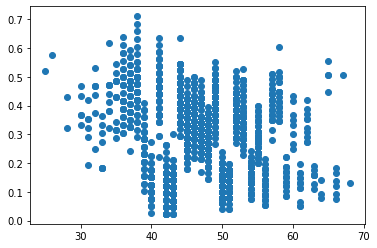

In [44]:
plt.scatter(target_annotations_randomized, target_degree_ratio_randomized)

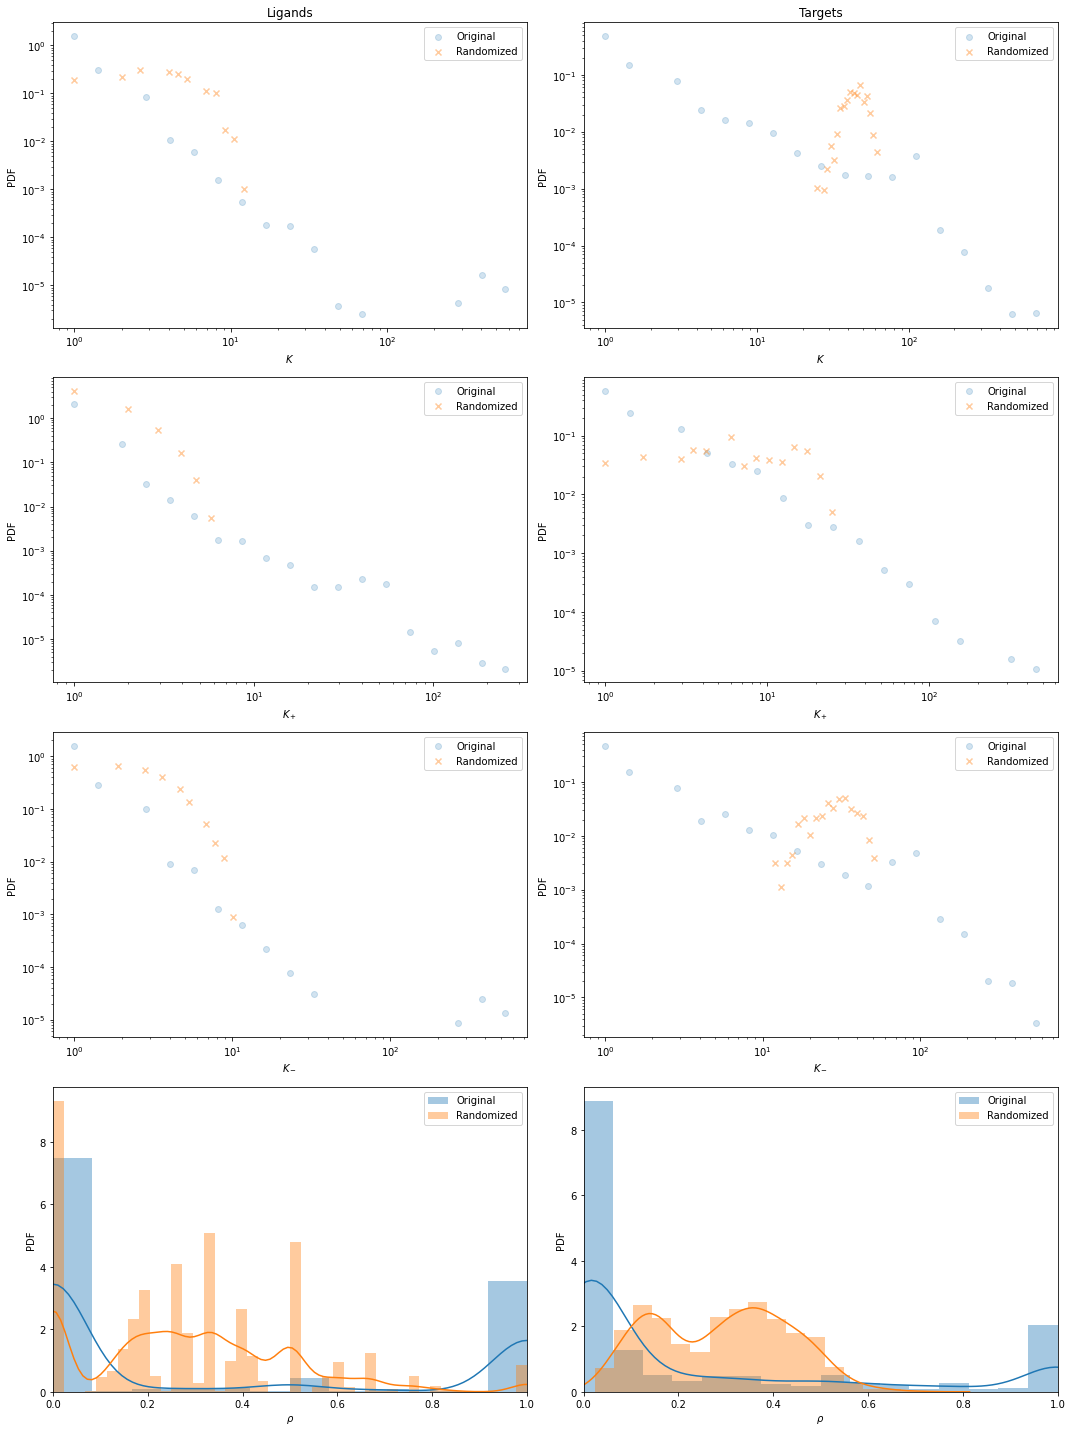

In [45]:
fig, axs = plt.subplots(4, 2, figsize=(15,20))

binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_annotations_bindingDB,B = 20)
axs[0, 0].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_annotations_randomized,B = 20)
axs[0, 0].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('$K$')
axs[0, 0].set_ylabel('PDF')
axs[0, 0].set_title('Ligands')
axs[0, 0].legend()

binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_pos_degree_bindingDB,B = 20)
axs[1, 0].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_pos_degree_randomized,B = 20)
axs[1, 0].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('$K_+$')
axs[1, 0].set_ylabel('PDF')
axs[1, 0].legend()

binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_neg_degree_bindingDB,B = 20)
axs[2, 0].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_neg_degree_randomized,B = 20)
axs[2, 0].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[2, 0].set_xscale('log')
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel('$K_-$')
axs[2, 0].set_ylabel('PDF')
axs[2, 0].legend()

#binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_neg_degree_original,B = 20)
sns.distplot(ligand_degree_ratio_bindingDB, ax=axs[3, 0], norm_hist=True, label='Original')
#axs[3, 0].hist(ligand_degree_ratio_bindingDB_original, label='Original',alpha=0.2)
#binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_neg_degree_shuffled,B = 20)
sns.distplot(ligand_degree_ratio_randomized, ax=axs[3, 0], norm_hist=True, label='Randomized')
#axs[3, 0].hist(ligand_degree_ratio_bindingDB_shuffled, label='Randomized Kd', alpha=0.2)
#axs[3, 0].set_xscale('log')
#axs[3, 0].set_yscale('log')
axs[3, 0].set_xlabel(r'$\rho$')
axs[3, 0].set_ylabel('PDF')
axs[3, 0].legend()
axs[3, 0].set_xlim([0.0, 1.0])

################################################################################################

binned_deg_ann, binned_ki_ann = log_binning_distribution(target_annotations_bindingDB,B = 20)
axs[0, 1].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(target_annotations_randomized,B = 20)
axs[0, 1].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('$K$')
axs[0, 1].set_ylabel('PDF')
axs[0, 1].set_title('Targets')
axs[0, 1].legend()

binned_deg_ann, binned_ki_ann = log_binning_distribution(target_pos_degree_bindingDB,B = 20)
axs[1, 1].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(target_pos_degree_randomized,B = 20)
axs[1, 1].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('$K_+$')
axs[1, 1].set_ylabel('PDF')
axs[1, 1].legend()

binned_deg_ann, binned_ki_ann = log_binning_distribution(target_neg_degree_bindingDB,B = 20)
axs[2, 1].scatter(binned_deg_ann, binned_ki_ann, label='Original',alpha=0.2)
binned_deg_ann, binned_ki_ann = log_binning_distribution(target_neg_degree_randomized,B = 20)
axs[2, 1].scatter(binned_deg_ann, binned_ki_ann, label='Randomized', marker='x', alpha=0.4)
axs[2, 1].set_xscale('log')
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel('$K_-$')
axs[2, 1].set_ylabel('PDF')
axs[2, 1].legend()

#binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_neg_degree_original,B = 20)
sns.distplot(target_degree_ratio_bindingDB, ax=axs[3, 1], norm_hist=True, label='Original')
#axs[3, 0].hist(ligand_degree_ratio_bindingDB_original, label='Original',alpha=0.2)
#binned_deg_ann, binned_ki_ann = log_binning_distribution(ligand_neg_degree_shuffled,B = 20)
sns.distplot(target_degree_ratio_randomized, ax=axs[3, 1], norm_hist=True, label='Randomized')
#axs[3, 0].hist(ligand_degree_ratio_bindingDB_shuffled, label='Randomized Kd', alpha=0.2)
#axs[3, 0].set_xscale('log')
#axs[3, 0].set_yscale('log')
axs[3, 1].set_xlabel(r'$\rho$')
axs[3, 1].set_ylabel('PDF')
axs[3, 1].legend()
axs[3, 1].set_xlim([0.0, 1.0])

fig.tight_layout()

# Duplex Configuration Model

In [46]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(randomized_dataframe, test_size=0.3)

In [48]:
train.to_csv('../data/experiment_4d_adjusted/train.csv')
test.to_csv('../data/experiment_4d_adjusted/test.csv')

In [49]:
ligands = list(set(train['SMILES'].tolist()))
targets = list(set(train['Target Sequence'].tolist()))

In [50]:
ligands_degree_dict = dict()

for smile_chem in tqdm(ligands):
    sum_df = train[train['SMILES'] == smile_chem]
    ligands_degree_dict[smile_chem] = dict()
    ligands_degree_dict[smile_chem]['deg_0'] = len(sum_df[sum_df['Label'] == 0])
    ligands_degree_dict[smile_chem]['deg_1'] = len(sum_df[sum_df['Label'] == 1])
    
targets_degree_dict = dict()

for aa_target in tqdm(targets):
    sum_df = train[train['Target Sequence'] == aa_target]
    targets_degree_dict[aa_target] = dict()
    targets_degree_dict[aa_target]['deg_0'] = len(sum_df[sum_df['Label'] == 0])
    targets_degree_dict[aa_target]['deg_1'] = len(sum_df[sum_df['Label'] == 1])
    
degree_train_1_0_ligands = [ligands_degree_dict[key_val]['deg_1'] for key_val in tqdm(ligands)]
degree_train_0_1_ligands = [ligands_degree_dict[key_val]['deg_0'] for key_val in tqdm(ligands)]

degree_train_1_0_targets = [targets_degree_dict[key_val]['deg_1'] for key_val in tqdm(targets)]
degree_train_0_1_targets = [targets_degree_dict[key_val]['deg_0'] for key_val in tqdm(targets)]

100%|██████████| 1507/1507 [00:00<00:00, 1083630.40it/s]


In [51]:
with open('../data/experiment_4d_adjusted/degreetrain10ligands.txt', 'w') as file:
    for degree in degree_train_1_0_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/experiment_4d_adjusted/degreetrain01ligands.txt', 'w') as file:
    for degree in degree_train_0_1_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/experiment_4d_adjusted/degreetrain10targets.txt', 'w') as file:
    for degree in degree_train_1_0_targets:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/experiment_4d_adjusted/degreetrain01targets.txt', 'w') as file:
    for degree in degree_train_0_1_targets:
        file.write("%i\n" % degree)
        
file.close()

textfile = open("../data/experiment_4d_adjusted/ligands.txt", "w")
for element in ligands:
    textfile.write(element + "\n")
textfile.close()

textfile = open("../data/experiment_4d_adjusted/targets.txt", "w")
for element in targets:
    textfile.write(element + "\n")
textfile.close()

In [52]:
summat10 = np.loadtxt(open("../data/experiment_4d_adjusted/summat10.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run
summat01 = np.loadtxt(open("../data/experiment_4d_adjusted/summat01.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run 

In [53]:
train_pos = train[train['Label'] == 1]
train_neg = train[train['Label'] == 0]

pos_deg_0_ligands = []
pos_deg_0_targets = []
neg_deg_0_ligands = []
neg_deg_0_targets = []

ligand_degree_ratio = dict()
ligand_all_average = []

for ligand in tqdm(ligands):
    pos_deg = ligands_degree_dict[ligand]['deg_1']
    neg_deg = ligands_degree_dict[ligand]['deg_0']
    if pos_deg + neg_deg != 0:
        ligand_degree_ratio[ligand] = dict()
        ligand_degree_ratio[ligand]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
        ligand_degree_ratio[ligand]['deg_avg'] = pos_deg / len(targets) 
        ligand_all_average.append(pos_deg / len(targets))
    if pos_deg == 0:
        pos_deg_0_ligands.append(ligand)
    if neg_deg == 0:
        neg_deg_0_ligands.append(ligand)
    
ligands_all_avg = sum(ligand_all_average) / len(ligands)

targets_degree_ratio = dict()
target_all_average = []

for target in tqdm(targets):
    pos_deg = targets_degree_dict[target]['deg_1']
    neg_deg = targets_degree_dict[target]['deg_0']
    if pos_deg + neg_deg != 0:
        targets_degree_ratio[target] = dict()
        targets_degree_ratio[target]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
        targets_degree_ratio[target]['deg_avg'] = pos_deg / len(ligands)
        target_all_average.append(pos_deg / len(ligands))
    if pos_deg == 0:
        pos_deg_0_targets.append(target)
    if neg_deg == 0:
        neg_deg_0_targets.append(target)
    
targets_all_avg = sum(target_all_average) / len(targets)

100%|██████████| 1507/1507 [00:00<00:00, 376799.77it/s]


In [54]:
## Annotated means the node has at least 1 binding information

pos_annotated_ligands = list(set(ligands)-set(pos_deg_0_ligands))
pos_annotated_targets = list(set(targets)-set(pos_deg_0_targets))

neg_annotated_ligands = list(set(ligands)-set(neg_deg_0_ligands))
neg_annotated_targets = list(set(targets)-set(neg_deg_0_targets))

In [55]:
test_probabilty_predicted_conditioned = []

## Average conditional probability
p10_avg = np.mean(summat10)
p01_avg = np.mean(summat01)
average_conditional_probability = p10_avg / (p10_avg + p01_avg)

for index, row in tqdm(test.iterrows()):      
    
    if row['SMILES'] in pos_annotated_ligands and row['Target Sequence'] in pos_annotated_targets:
        p10 = summat10[ligands.index(row['SMILES']),targets.index(row['Target Sequence'])]
        p01 = summat01[ligands.index(row['SMILES']),targets.index(row['Target Sequence'])]
        p10_conditioned = p10 / (p10 + p01)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['SMILES'] in pos_annotated_ligands and row['Target Sequence'] not in pos_annotated_targets:
        p10_conditioned = ligand_degree_ratio[row['SMILES']]['deg_ratio']  ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['SMILES'] not in pos_annotated_ligands and row['Target Sequence'] in pos_annotated_targets:
        p10_conditioned = targets_degree_ratio[row['Target Sequence']]['deg_ratio'] ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)

    else:
        p10_conditioned = average_conditional_probability
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        

21296it [00:20, 1054.85it/s]


In [150]:
#test_pos = test[test['Label'] == 1]
#test_neg = test[test['Label'] == 0]

#test = pd.concat([test_pos,test_neg.sample(n=len(test_pos))])

In [56]:
## Performance on the test dataset

print('AUC: ', roc_auc_score(test['Label'].tolist(), test_probabilty_predicted_conditioned))
print('AUP: ', average_precision_score(test['Label'].tolist(), test_probabilty_predicted_conditioned))

AUC:  0.6172139273719905
AUP:  0.35108015340765025


In [57]:
test['test_probabilty_predicted_conditioned'] = test_probabilty_predicted_conditioned
test = test[~test['test_probabilty_predicted_conditioned'].isna()]

train_ligands = list(set(train['SMILES'].tolist()))
train_targets = list(set(train['Target Sequence'].tolist()))

test_minus_train_ligands = list(set(test['SMILES'].tolist()).difference(train_ligands))
test_minus_train_targets = list(set(test['Target Sequence'].tolist()).difference(train_targets))

print('Seen ligands: ', len(train_ligands))
print('Seen targets: ', len(train_targets))
print('Unseen ligands: ', len(test_minus_train_ligands))
print('Unseen targets: ', len(test_minus_train_targets))

Seen ligands:  13067
Seen targets:  1507
Unseen ligands:  250
Unseen targets:  0


/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
# Unseen Edges

test_unseen_edges = test[test['SMILES'].isin(train_ligands) & test['Target Sequence'].isin(train_targets)]
print('Unseen edges: ', len(test_unseen_edges))

print('AUC: ', roc_auc_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['test_probabilty_predicted_conditioned']))
print('AUP: ', average_precision_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['test_probabilty_predicted_conditioned']))

Unseen edges:  20774
AUC:  0.616872422273363
AUP:  0.3506376571003319


In [288]:
# Unseen Targets

test_unseen_targets = test[test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen targets: ', len(test_unseen_targets))

append = pd.DataFrame()

append['SMILES'] = ['x']
append['Target Sequence'] = ['y']
append['Label'] = [1.0]
append['test_probabilty_predicted_conditioned'] = [np.mean(test_unseen_targets['test_probabilty_predicted_conditioned'].tolist())]

test_unseen_targets = pd.concat([test_unseen_targets,append])

print('AUC: ', roc_auc_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['test_probabilty_predicted_conditioned']))
print('AUP: ', average_precision_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['test_probabilty_predicted_conditioned']))

Unseen targets:  0


/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [289]:
# Unseen Nodes

test_unseen_nodes = test[test['SMILES'].isin(test_minus_train_ligands) & test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen nodes: ', len(test_unseen_nodes))

append = pd.DataFrame()

append['SMILES'] = ['x']
append['Target Sequence'] = ['y']
append['Label'] = [1.0]
append['test_probabilty_predicted_conditioned'] = [np.mean(test_unseen_nodes['test_probabilty_predicted_conditioned'].tolist())]

test_unseen_nodes = pd.concat([test_unseen_nodes,append])

print('AUC: ', roc_auc_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['test_probabilty_predicted_conditioned']))
print('AUP: ', average_precision_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['test_probabilty_predicted_conditioned']))

Unseen nodes:  0


/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Comparison with Original

In [59]:
original_test = pd.read_csv('../data/Transformer_CNN_test_w_config_preds_fold2.csv')

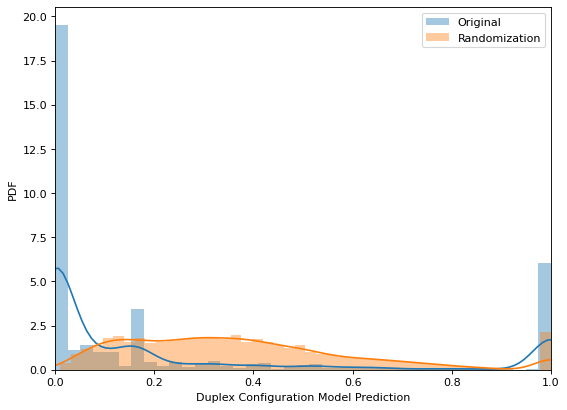

In [60]:
figure(figsize=(8, 6), dpi=80)

sns.distplot(original_test['duplex_config_prediction'].tolist(),  norm_hist=True, label='Original')
sns.distplot(test_probabilty_predicted_conditioned,  norm_hist=True, label='Randomization')
plt.legend()
plt.xlim([0,1])
plt.xlabel('Duplex Configuration Model Prediction')
plt.ylabel('PDF')
plt.show()

In [61]:
print('Older mean and std of duplex prediction: ', np.mean(original_test['duplex_config_prediction'].tolist()), np.std(original_test['duplex_config_prediction'].tolist()))
print('New mean and std of duplex prediction: ', np.mean(test_probabilty_predicted_conditioned), np.std(test_probabilty_predicted_conditioned))

Older mean and std of duplex prediction:  0.23615038775267627 0.36227473125684373
New mean and std of duplex prediction:  0.37197691772958436 0.2338427516813299
